# Analysis on spatial variables And Time Since Construction

In [24]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

# Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

data_test = pd.read_parquet(Path("data") / "final_test.parquet")
data["date"]

48321    2020-09-01 02:00:00
48324    2020-09-01 03:00:00
48327    2020-09-01 04:00:00
48330    2020-09-01 15:00:00
48333    2020-09-01 18:00:00
                 ...        
929175   2021-09-09 06:00:00
929178   2021-09-09 10:00:00
929181   2021-09-09 15:00:00
929184   2021-09-09 22:00:00
929187   2021-09-09 23:00:00
Name: date, Length: 496827, dtype: datetime64[us]

and in particular the number of unique entries in each column,

In [18]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

In [ ]:
data[["counter_name", "counter_id"]].drop_duplicates().shape

(56, 2)

One on one correspondence between counter name and counter id.

In [13]:
data[["counter_name", "counter_technical_id"]].drop_duplicates().shape

(56, 2)

One to multiple correspondance between counter name and counter technical id.

In [14]:
data[["site_name", "site_id"]].drop_duplicates().shape

(30, 2)

One to one correspondance between site name and site id.

In [16]:
data[["site_id", "counter_technical_id"]].drop_duplicates().shape

(30, 2)

One to one correspondance between site name and counter technical id.

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [33]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_1398/1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


# Bike Count per Month per Counter Name


Let's visualize the data, starting from the spatial distribution of counters on the map

/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_10631/667579296.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.pivot_table(index=data['date'].dt.to_period('M'), columns='counter_name', values='log_bike_count', aggfunc='sum')


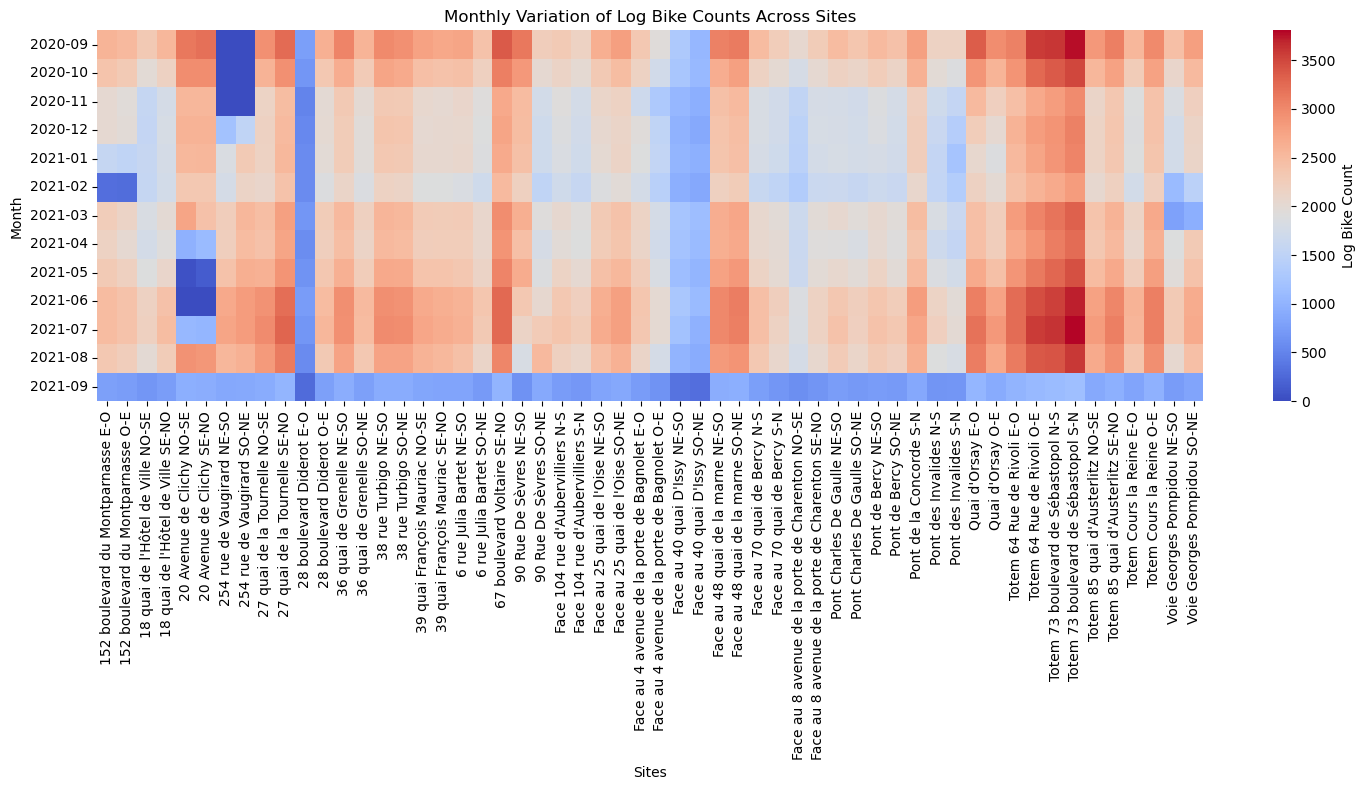

In [22]:
# Pivot table for heatmap
heatmap_data = data.pivot_table(index=data['date'].dt.to_period('M'), columns='counter_name', values='log_bike_count', aggfunc='sum')

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", cbar_kws={'label': 'Log Bike Count'})
plt.title('Monthly Variation of Log Bike Counts Across Sites')
plt.xlabel('Sites')
plt.ylabel('Month')
plt.tight_layout()
plt.show()


1. There are counters where the log bike count is zero for some months (254 rue de Vaugirard)
2. There is some general patern

# Log Bike Count per day per conter name

/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_10631/3170216101.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["counter_id", pd.Grouper(freq="1D", key="date")])


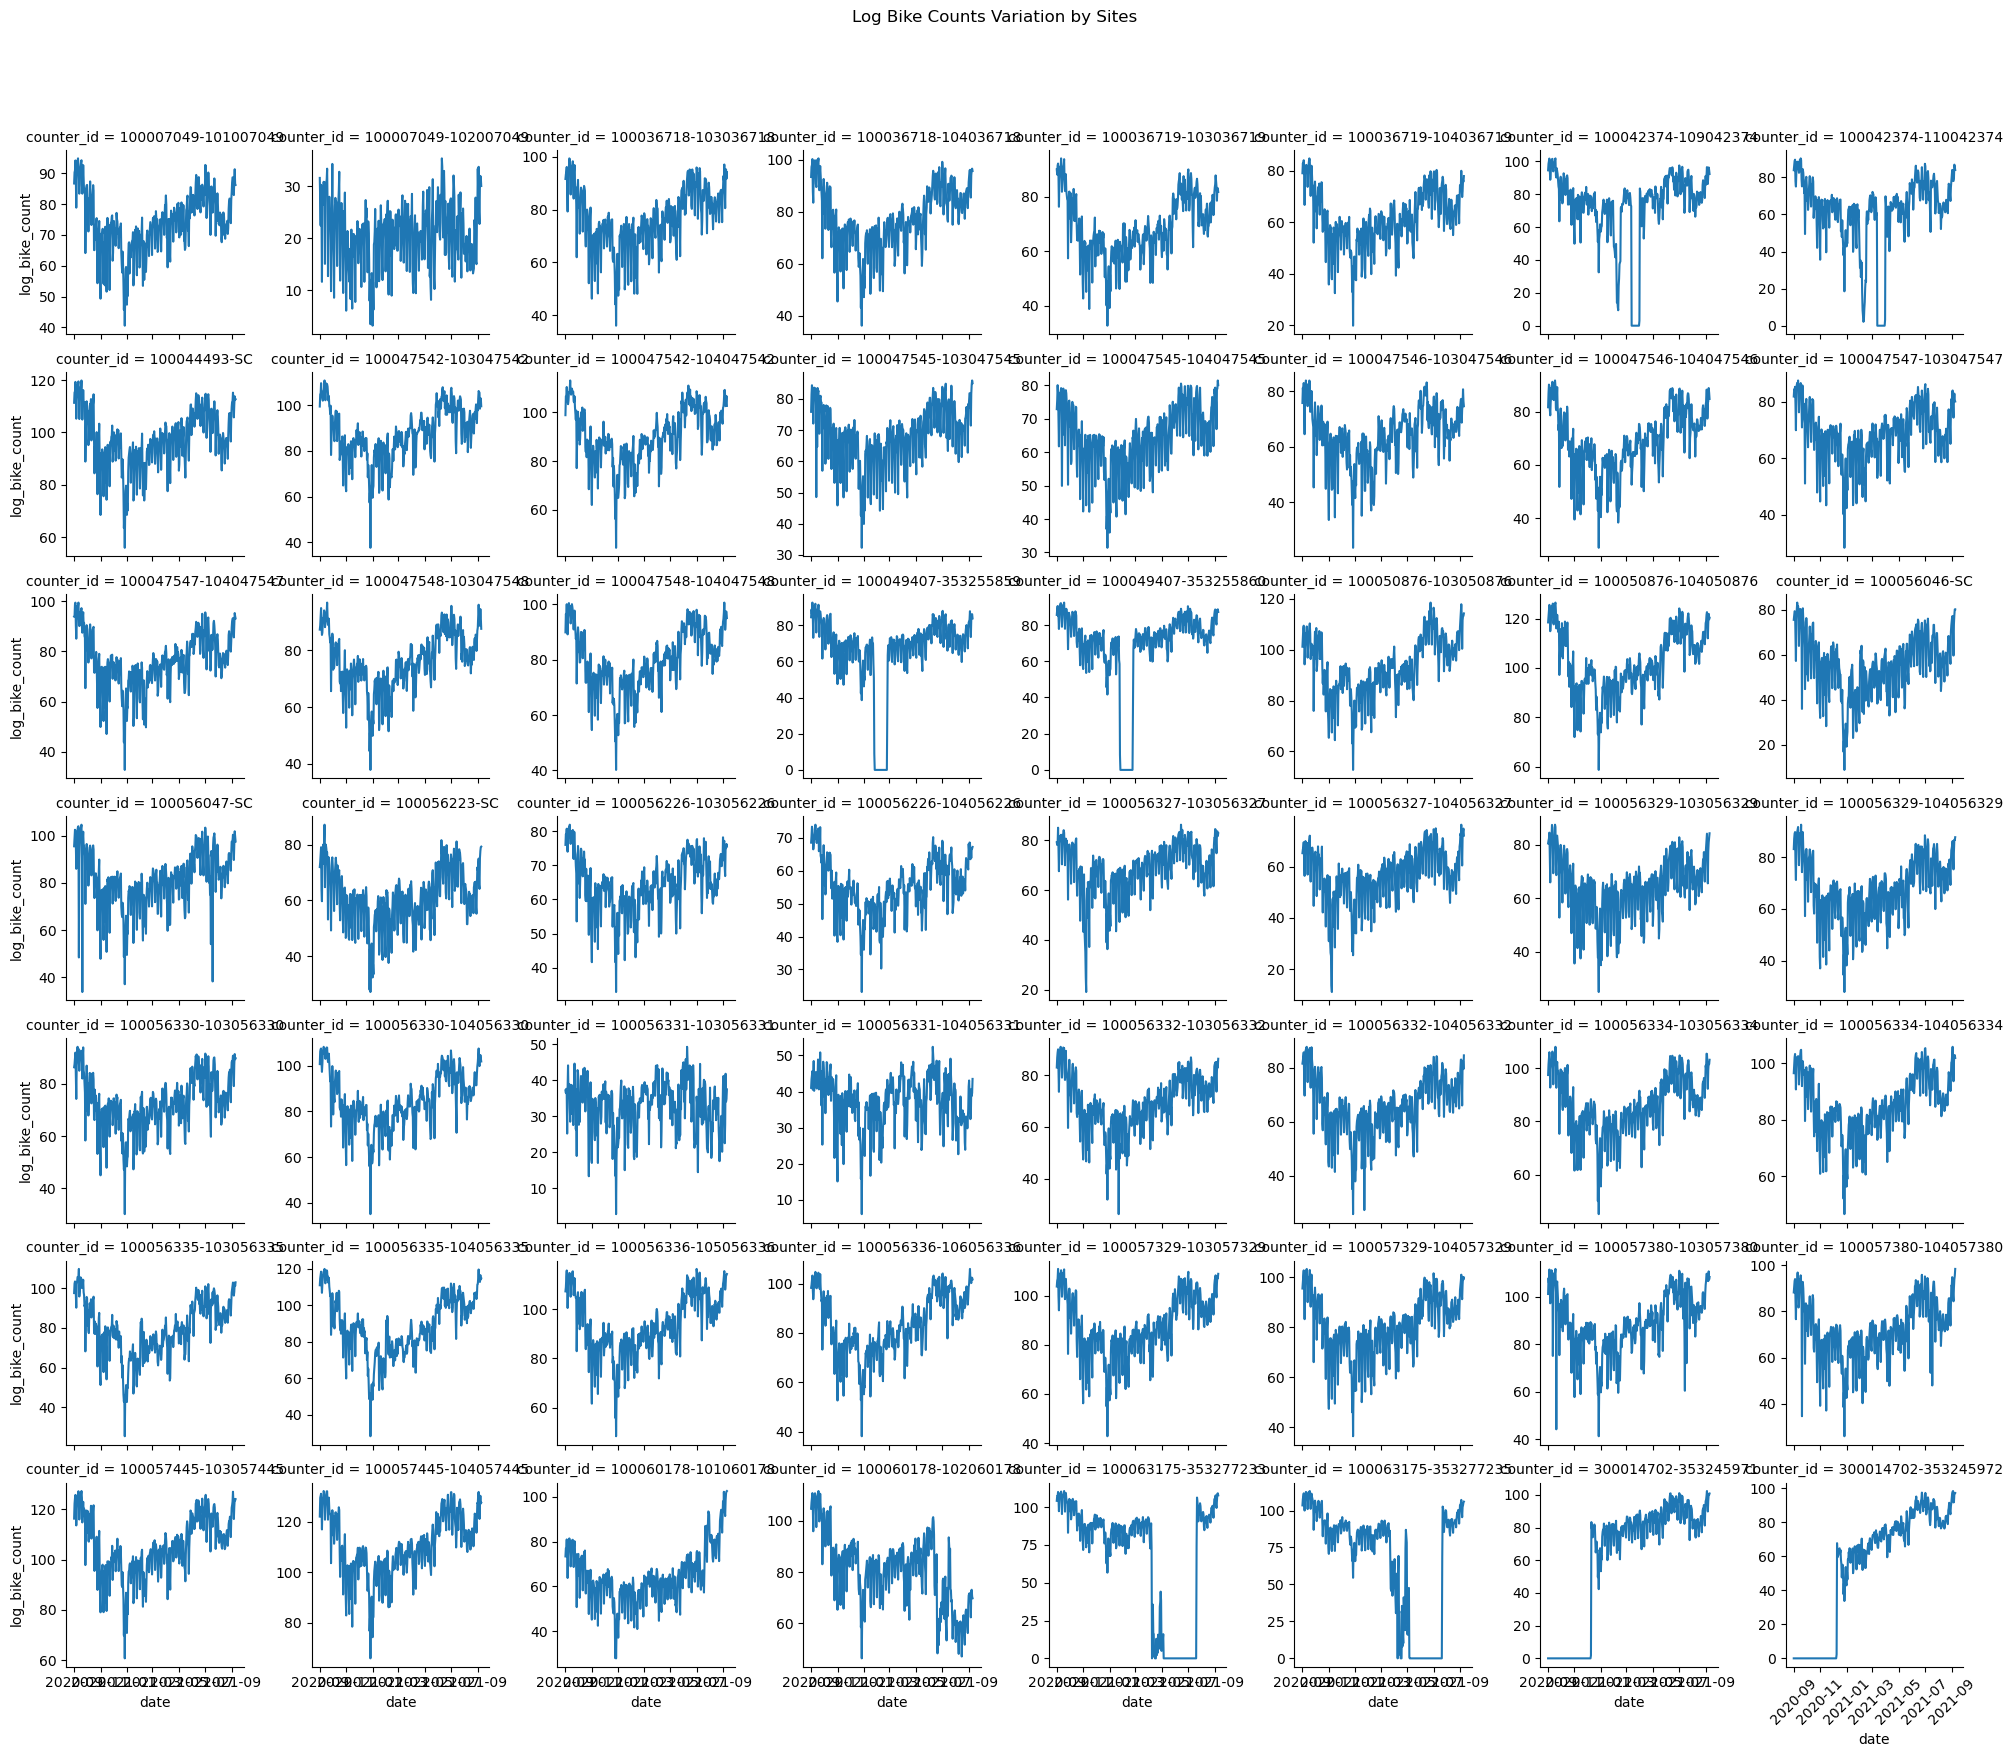

In [ ]:
grouped_data = (
    data.groupby(["counter_id", pd.Grouper(freq="1D", key="date")])
    ["log_bike_count"].sum()
    .to_frame()
)
grouped_data = grouped_data.reset_index()

g = sns.FacetGrid(grouped_data, col="counter_id", col_wrap=8, height=2.5, sharey=False)
g.map(sns.lineplot, 'date', 'log_bike_count')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Log Bike Counts Variation by Sites')
plt.xticks(rotation=45)
plt.show()

1. Outliers: days when no bikes were registered because of: not constructed; went offline
2. Same overall pattern

# Log Bike Counter averaged per day per Counter name

/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_10631/4265058517.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["counter_id", 'day_of_week'])


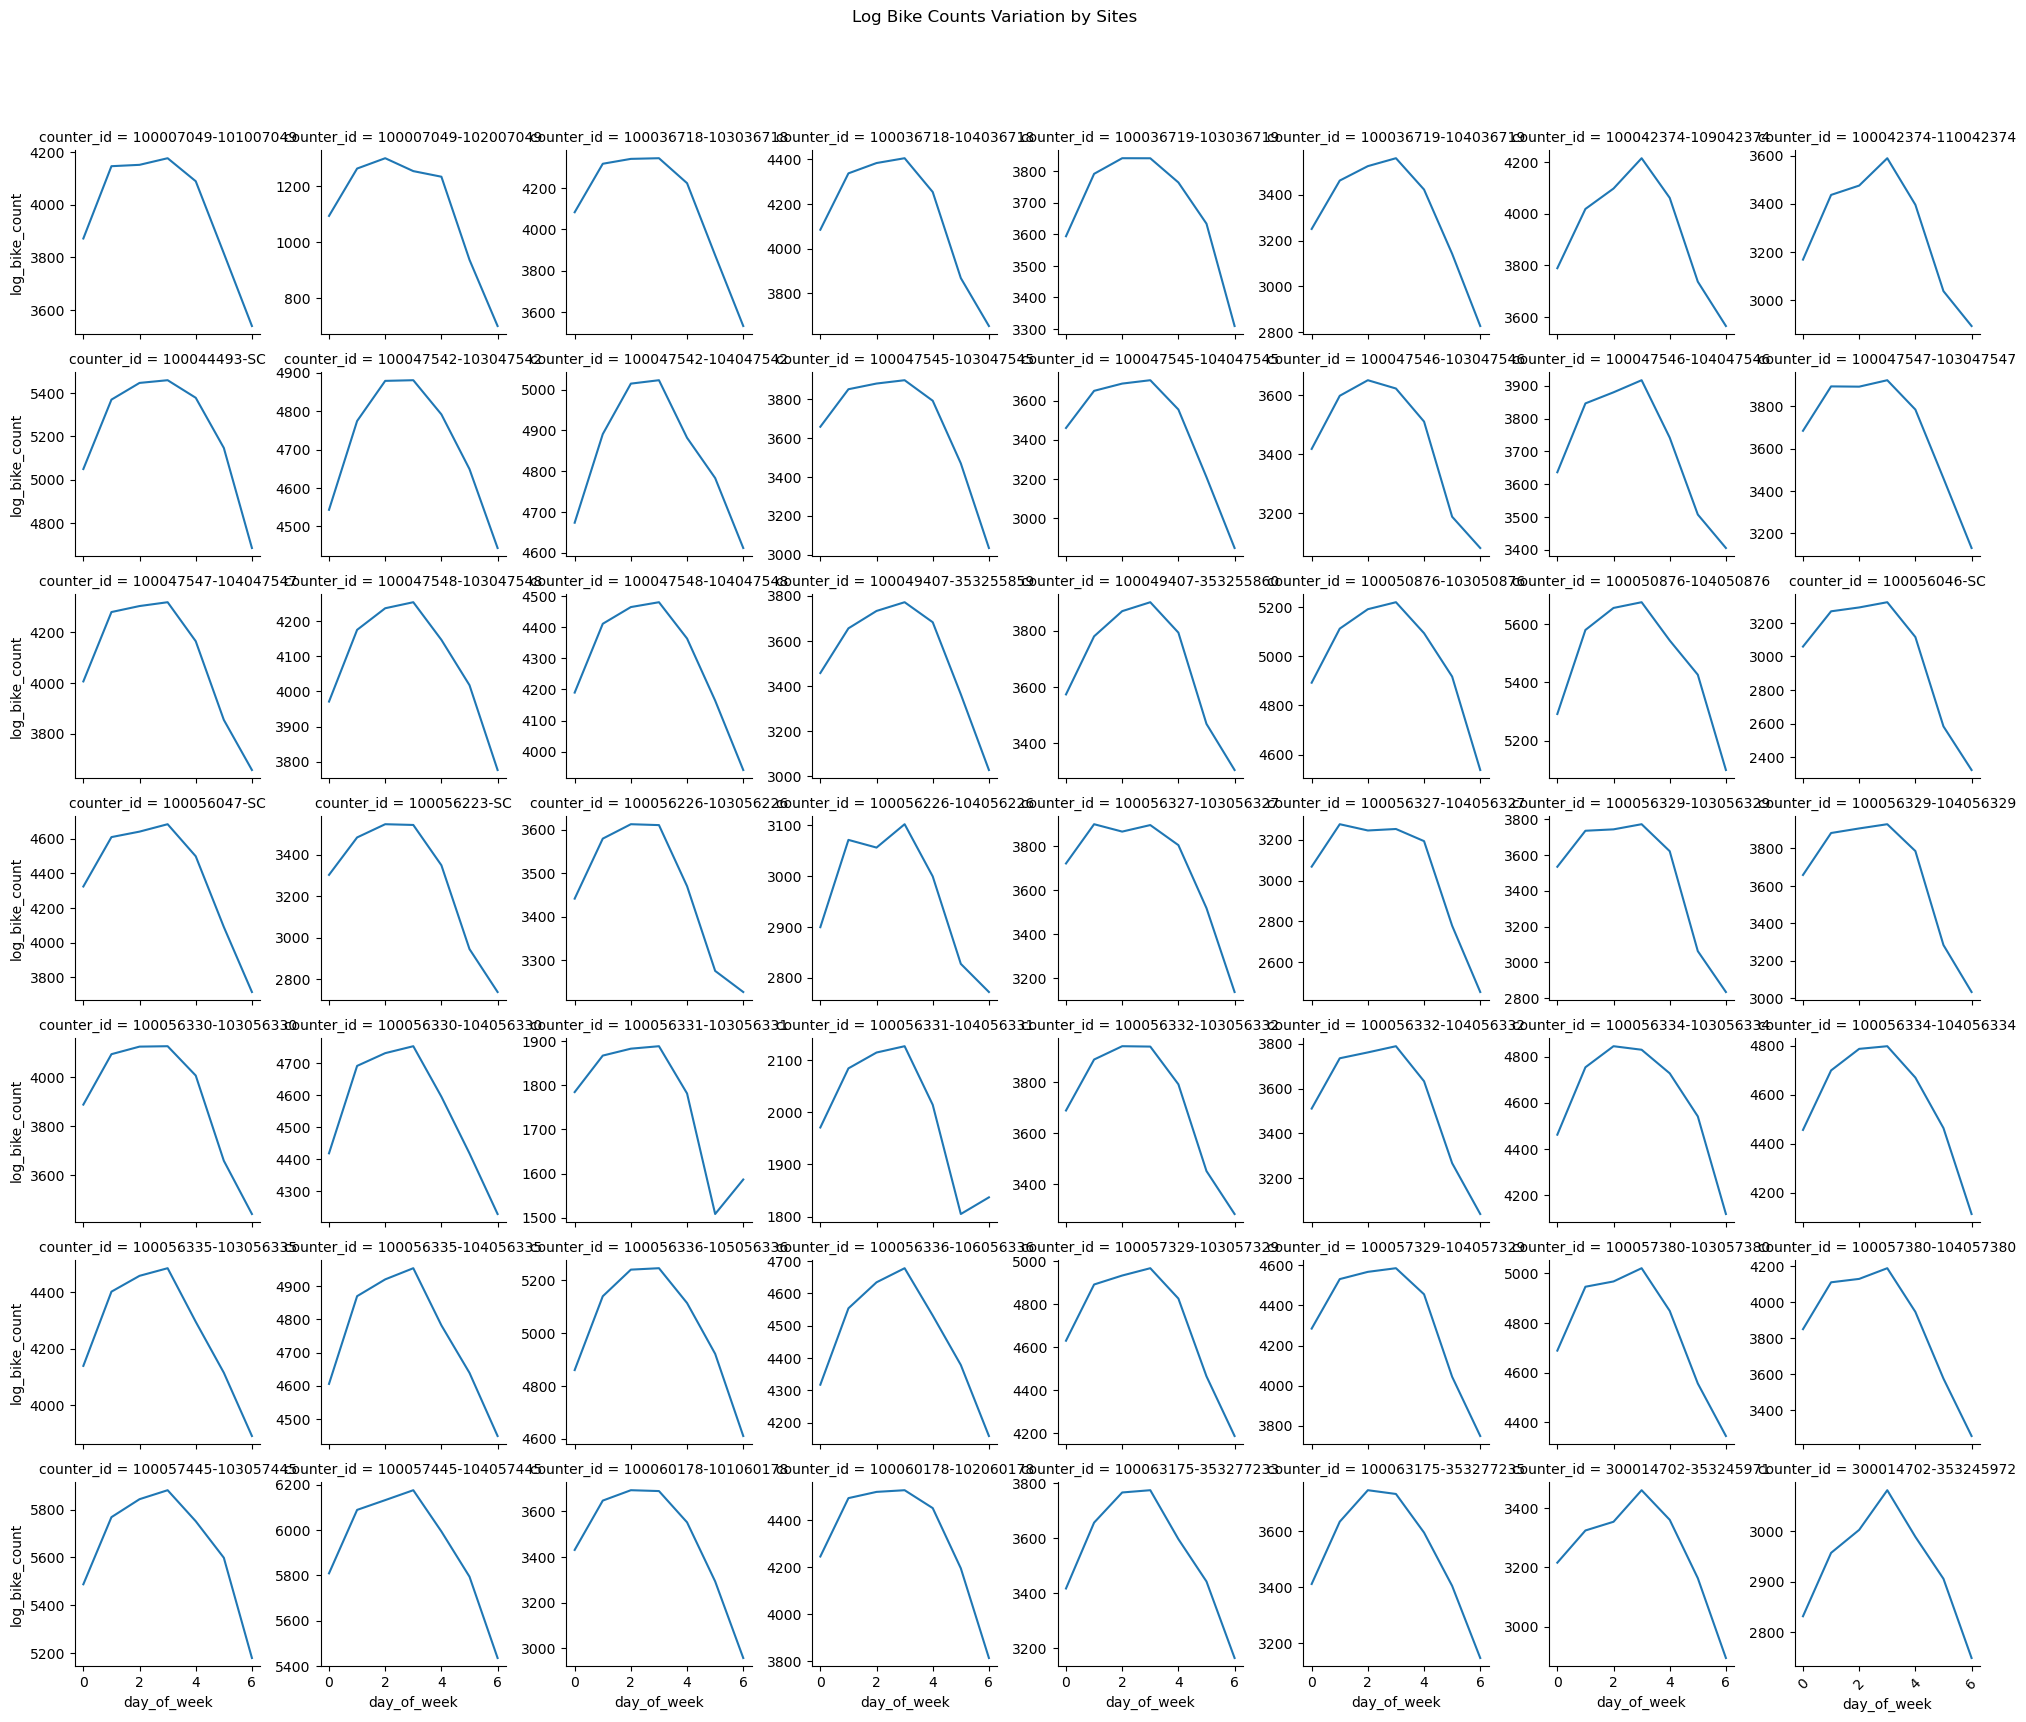

In [31]:
data['day_of_week'] = data['date'].dt.dayofweek

grouped_data = (
    data.groupby(["counter_id", 'day_of_week'])
    ["log_bike_count"].sum()
    .to_frame()
)
grouped_data = grouped_data.reset_index()

g = sns.FacetGrid(grouped_data, col="counter_id", col_wrap=8, height=2.5, sharey=False)
g.map(sns.lineplot, 'day_of_week', 'log_bike_count')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Log Bike Counts Variation by Sites')
plt.xticks(rotation=45)
plt.show()

0 is Monday

1. Overall, is very similar

# Influence of Time since construction on Log Bike Count

In [33]:
data["counter_installation_date"].drop_duplicates().shape

(22,)

/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_10631/1003956911.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name"])["log_bike_count"].sum()


<Axes: xlabel='counter_installation_date', ylabel='log_bike_count'>

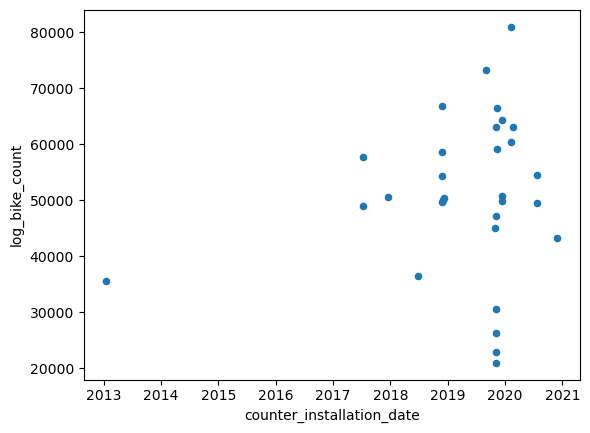

In [46]:
(
    data.groupby(["site_name"])["log_bike_count"].sum()
    .to_frame()
    .merge(data[["site_name", "counter_installation_date"]].drop_duplicates(), "left", "site_name")
    .sort_values(by="counter_installation_date")
    .plot.scatter(x="counter_installation_date", y="log_bike_count")
)